# Исследование надежности заемщиков


**Заказчик — кредитный отдел банка.**

**Задача:**
Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.
Результаты исследования будут учтены при построении модели кредитного скоринга 

**Описание данных:**

* **children** — количество детей в семье
* **days_employed** — общий трудовой стаж в днях
* **dob_years** — возраст клиента в годах
* **education** — уровень образования клиента
* **education_id** — идентификатор уровня образования
* **family_status** — семейное положение
* **family_status_id** — идентификатор семейного положения
* **gender** — пол клиента
* **income_type** — тип занятости
* **debt** — имел ли задолженность по возврату кредитов
* **total_income** — ежемесячный доход
* **purpose** — цель получения кредита

## Загрузка данных

In [1]:
import pandas as pd
import phik
import seaborn as sns

In [2]:
try:
    data = pd.read_csv('/datasets/data.csv')
except:
    pass

Выведем 5 строчек датасета:

In [3]:
data.sample(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
11781,2,-962.440424,39,высшее,0,женат / замужем,0,M,сотрудник,0,455246.047081,сделка с подержанным автомобилем
10237,0,-12761.820562,59,среднее,1,вдовец / вдова,2,F,сотрудник,0,150625.851649,покупка недвижимости
3070,0,-7809.310101,55,среднее,1,гражданский брак,1,M,компаньон,1,134244.983422,строительство жилой недвижимости
11215,0,-6538.318379,55,СРЕДНЕЕ,1,гражданский брак,1,M,сотрудник,0,139957.861428,сделка с автомобилем
15693,0,-795.339974,25,СРЕДНЕЕ,1,Не женат / не замужем,4,M,сотрудник,0,153536.867711,покупка своего жилья


Выведем основную информацию о датасете:

In [4]:
data.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 11.3 MB


## Предобработка данных

### Обработка пропусков

In [5]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

В двух столбцах есть пропущенные значения. Заполним один из них медианой.

In [6]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

In [7]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64

### Обработка аномальных значений

В данных могут встречаться артефакты (аномалии) — значения, которые не отражают действительность и появились по какой-то ошибке. таким артефактом будет отрицательное количество дней трудового стажа в столбце days_employed.

In [8]:
data['days_employed'] = data['days_employed'].abs()

Для каждого типа занятости выведем медианное значение трудового стажа days_employed в днях.

In [9]:
data.groupby('income_type')['days_employed'].agg('median')

income_type
безработный        366413.652744
в декрете            3296.759962
госслужащий          2689.368353
компаньон            1547.382223
пенсионер          365213.306266
предприниматель       520.848083
сотрудник            1574.202821
студент               578.751554
Name: days_employed, dtype: float64

перечень уникальных значений столбца children

In [10]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

 В столбце children есть два аномальных значения. Удалим строки, в которых встречаются такие аномальные значения из датафрейма data.

In [11]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

In [12]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Заполним пропуски в столбце days_employed медианными значениями по каждого типа занятости income_type

In [13]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['days_employed'].isna()), 'days_employed'] = \
    data.loc[(data['income_type'] == t), 'days_employed'].median()

In [14]:
data.isna().sum()

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

Пропуски обработали!

### Изменение типов данных

Заменим вещественный тип данных в столбце total_income на целочисленный с помощью метода astype().

In [15]:
data['total_income'] = data['total_income'].astype(int)

### Обработка дубликатов

Обработаем неявные дубликаты в столбце education. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. 

In [16]:
data['education'] = data['education'].str.lower()

In [17]:
data.duplicated().sum()

71

In [18]:
data = data.drop_duplicates()

## Категоризация данных

На основании диапазонов, указанных ниже, создадим в датафрейме data столбец total_income_category с категориями:

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.

In [19]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [20]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

Выведем на экран перечень уникальных целей взятия кредита из столбца purpose.

In [21]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

Создадим функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

In [22]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [23]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

## EDA

In [24]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы


### Есть ли зависимость между количеством детей и возвратом кредита в срок?

**Для ответа на этот вопрос сагрегируем данные. Поскольку feature debt является бинарной, то среднее по этому столбцу, в зависимости от категории покажет нам долю невозврата. Итак, сгруппируем данные по children**

In [25]:
# применим три функции агрегации

data.groupby('children')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
children,,,
0,14091,0.075438,1063
1,4808,0.092346,444
2,2052,0.094542,194
3,330,0.081818,27
4,41,0.097561,4
5,9,0.000000,0


**Из таблицы я вижу 6 категорий, от 0 до 5 детей. И наблюдается следующее:**

* Для бездетных - 7.5% невозврат
* Для 1 ребенка  - 9.2% невозврат
* Для 2 детей - 9.4% невозврат
* Для 3 детей - 8.1% невозврат

**Но поскольку последние 2 группы содержат мало данных, я предлагаю разделить данные о детях на следующие категории:**

* нет детей
* 1 ребенок
* 2 ребенка
* многодетные (>2 детей)

In [26]:
# напишем функцию для категоризации детей)):

def category_cheldren(children):
    try:
        if children == 0:
            return 'нет детей'

        elif children == 1:
            return '1 ребенок'

        elif children >= 2:
            return 'многодетные'

    except:
            pass

In [27]:
# можно попробовать включить 2 детей в категорию многодетных и посмотреть, что будет:
    
data['category_children_2'] = data['children'].apply(category_cheldren)

In [28]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,total_income_category,purpose_category,category_children_2
0,1,8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,B,операции с недвижимостью,1 ребенок
1,1,4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,C,операции с автомобилем,1 ребенок
2,0,5623.422610,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,C,операции с недвижимостью,нет детей
3,3,4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,B,получение образования,многодетные
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,C,проведение свадьбы,нет детей


**Сагрегируем данные еще раз, но теперь на новый столбец category_children.**

In [29]:
# сагрегируем и отсортируем по возрастанию доли невозврата
data.groupby('category_children_2')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
category_children_2,,,
1 ребенок,4808,0.092346,444
многодетные,2432,0.092516,225
нет детей,14091,0.075438,1063


**В целом, мы видим динамику:**

* Наибольший возврат наблюдается у людей без детей
* С увеличением количества детей, доля возврата уменьшается


**Теперь воспользуемся коэффициентом корреляции phik для выявления зависимости между целевым столбцом debt и нецелевыми столбцами.**

In [30]:
# расчет phik
phik = data.phik_matrix()

interval columns not set, guessing: ['children', 'days_employed', 'dob_years', 'education_id', 'family_status_id', 'debt', 'total_income']


In [31]:
# Отмечу, что коэффициент корреляции phik фиксирует и нелинейные зависимости
phik['debt'].sort_values(ascending=False)

debt                     1.000000
income_type              0.083525
dob_years                0.068599
purpose_category         0.050060
education                0.047145
education_id             0.047145
children                 0.037015
gender                   0.033420
purpose                  0.032239
family_status            0.027289
family_status_id         0.027289
days_employed            0.024321
total_income             0.017078
category_children_2      0.016724
total_income_category    0.016502
Name: debt, dtype: float64

**Мы видим, что total_income_category влияет на целевую переменную debt**

<Axes: >

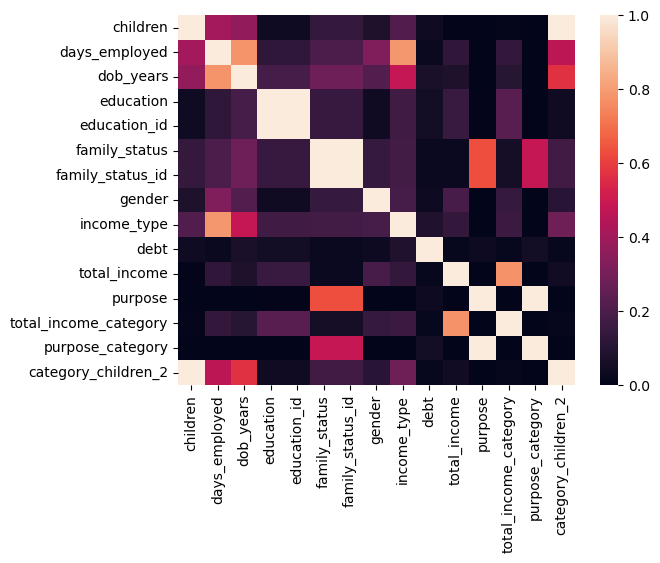

In [32]:
# построим heatmap для визуализации влияния переменных друг на друга.
sns.heatmap(phik)

**По горячей карте мы можем отслуживать значимость переменных на итогую целевую переменную**

**Вывод: зависимость между количеством детей и возвратом кредита в срок есть:**
* Наибольшая доля возврата наблюдается у людей без детей;
* С увеличением количества детей наблюдается увеличение доли невозврата! 

### Есть ли зависимость между семейным положением и возвратом кредита в срок?¶

**Для ответа на этот вопрос сагрегируем данные. Поскольку feature debt является бинарной, то среднее по этому столбцу, в зависимости от категории покажет нам долю невозврата. Итак, сгруппируем данные по family_status**

In [33]:
# применим три функции агрегации

data.groupby('family_status')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
family_status,,,
Не женат / не замужем,2796,0.097639,273
в разводе,1189,0.070648,84
вдовец / вдова,951,0.066246,63
гражданский брак,4134,0.093130,385
женат / замужем,12261,0.075606,927


**Из таблицы я вижу 5 категорий. И наблюдается следующее:**

* Не женат / не замужем - 9.7% невозврат
* в разводе	            - 7% невозврат
* вдовец / вдова        - 6.6% невозврат
* гражданский брак	    - 9.3% невозврат
* женат / замужем	    - 7.5% невозврат



**В целом, мы видим динамику:**

* Наименьший невозврат наблюдается у категории (вдовец / вдова) и категории (в разводе) и (женат / замужем)
* Наибольший невозврат наблюдается у тех, кто в гражданком браке, не женет / не замужем

**Вывод: зависимость между семейным положением и возвратом кредита в срок есть. Семейный человек (или в разводе) с большей вероятностью вернет кредит. Те, кто находятся в гражданком браке или вообще не были в браке, имею меньше шансов на возврат кредита!** 

In [34]:
# Изучив влияние количества детей и семейного положения сгруппируем их вместе, чтобы посмотреть влияние обеих 
# переменных на debt.

t = data.groupby(['family_status', 'category_children_2'])['debt'].agg(['count', 'mean', 'sum']).sort_values(by='category_children_2', ascending=False)
t

,,count,mean,sum
family_status,category_children_2,,,
Не женат / не замужем,нет детей,2262,0.092838,210
в разводе,нет детей,784,0.070153,55
вдовец / вдова,нет детей,847,0.062574,53
гражданский брак,нет детей,2730,0.083883,229
женат / замужем,нет детей,7468,0.069095,516
Не женат / не замужем,многодетные,85,0.129412,11
в разводе,многодетные,93,0.086022,8
вдовец / вдова,многодетные,27,0.111111,3
гражданский брак,многодетные,409,0.092910,38


In [35]:
# Поскольку некоторых наблюдений мало - я отфильтрую данные с количеством наблюдений < 100, чтобы не сильно
# исказить результаты
# отсортирую по убыванию mean

t[t['count'] > 100].sort_values(by='mean', ascending=False)

,,count,mean,sum
family_status,category_children_2,,,
гражданский брак,1 ребенок,995,0.118593,118
Не женат / не замужем,1 ребенок,449,0.115813,52
гражданский брак,многодетные,409,0.092910,38
Не женат / не замужем,нет детей,2262,0.092838,210
женат / замужем,многодетные,1818,0.090759,165
гражданский брак,нет детей,2730,0.083883,229
женат / замужем,1 ребенок,2975,0.082689,246
в разводе,нет детей,784,0.070153,55
женат / замужем,нет детей,7468,0.069095,516


**Отвечая на вопрос исследования " влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок." - да, влияет. Если рассмтаривать влияние двух этих переменных на на факт погашения в срок, то отмечу следующее:**

* Самые Высокие шансы на НЕпогашение кредита имеют (неженатые и пары в гражанском браке) с 1 ребенком (примерно 11.6% невозврата)

* Самые низкие шансы на НЕпогашение кредита имеют вдовец/вдова без детей (примерно 6.2% невозврата)

In [36]:
data['family_status'].unique()

array(['женат / замужем', 'гражданский брак', 'вдовец / вдова',
       'в разводе', 'Не женат / не замужем'], dtype=object)

In [37]:
# Посмотрим подробнее на фичу семейное положение и изменю категоризацию на тех, кто был/есть в браке,
# гражданский брак, и тех, кто не был в браке. 

def family_status_category(status):
    try:
        if status == 'женат / замужем' or status == 'вдовец / вдова' or status == 'в разводе':
            return 'был в браке'
        elif status == 'гражданский брак':
            return 'гражданский брак'
        
        elif status == 'вдовец / вдова':
            return 'вдовец / вдова'        
        
        elif status == 'Не женат / не замужем':
            return 'НЕ был в браке'
    except:
        return 'нет категории'


In [38]:
data['family_status_category'] = data['family_status'].apply(family_status_category)

In [39]:
# Изучив влияние количества детей и семейного положения сгруппируем их вместе, чтобы посмотреть влияние обеих 
# переменных на debt.

t = data.groupby(['family_status_category',
                  'category_children_2'])['debt'].agg(['count', 'mean', 'sum'])
t

count      mean  sum
family_status_category category_children_2                      
НЕ был в браке         1 ребенок              449  0.115813   52
                       многодетные             85  0.129412   11
                       нет детей             2262  0.092838  210
был в браке            1 ребенок             3364  0.081451  274
                       многодетные           1938  0.090815  176
                       нет детей             9099  0.068579  624
гражданский брак       1 ребенок              995  0.118593  118
                       многодетные            409  0.092910   38
                       нет детей             2730  0.083883  229

In [40]:
# Поскольку некоторых наблюдений мало - я отфильтрую данные с количеством наблюдений > 100, чтобы не сильно
# исказить результаты
# отсортирую по убыванию mean

t[t['count'] > 100].sort_values(by='mean', ascending=False)

count      mean  sum
family_status_category category_children_2                      
гражданский брак       1 ребенок              995  0.118593  118
НЕ был в браке         1 ребенок              449  0.115813   52
гражданский брак       многодетные            409  0.092910   38
НЕ был в браке         нет детей             2262  0.092838  210
был в браке            многодетные           1938  0.090815  176
гражданский брак       нет детей             2730  0.083883  229
был в браке            1 ребенок             3364  0.081451  274
                       нет детей             9099  0.068579  624

**Вывод: Теперь хорошо наблюдается следующая зависимость:**
* Люди, которые были в браке и у них нет детей - имеют НАИБОЛЬШИЕ шансы на возврат кредита.
* Люди в гражданском браке с ребенком имеют НАИМЕНЬШИЕ шансы на возврат


### Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

**Для ответа на этот вопрос сагрегируем данные. Поскольку feature debt является бинарной, то среднее по этому столбцу, в зависимости от категории покажет нам долю невозврата. Итак, сгруппируем данные по уровню дохода, ранее мы категоризовали уровень дохода, результат находится в столбце total_income_category, где**
- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


In [41]:
# применим три функции агрегации

data.groupby('total_income_category')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
total_income_category,,,
A,25,0.080000,2
B,5014,0.070602,354
C,15921,0.084982,1353
D,349,0.060172,21
E,22,0.090909,2


**Из таблицы я вижу 5 категорий. И наблюдается следующее:**

- 0–30000 — `'E'` - 9% невозврата
- 30001–50000 — `'D'` - 6% невозврата
- 50001–200000 — `'C'` - 8.4% невозврата
- 200001–1000000 — `'B'`- 7% невозврата
- 1000001 и выше — `'A'` - 8% невозврата



**В целом, мы видим динамику:**

* Наименьший невозврат наблюдается у категории с доходом 30001–50000, наблюдается 6% невозврата
* Наибольший невозврат наблюдается у категории с наименьшим доходом 0–30000, наблюдается 9% невозврата

**Вывод: зависимость между уровнем дохода и возвратом кредита в срок есть. Люди с меньшим доходом имеют меньше шансов на возврат кредита, люди (скорее всего среднего класса ) с доходом 30001–50000 имеют бОльшие шансы на возврат кредита. Выводы справедливы, если учитывать, что количество наблюдений для категорий A и E достаточно.** 

In [42]:
# Попробую изменить категоризацию, чтобы включить малые группы в бОльшие:

def category_total_2(total):
    try:
        if total <= 200000:
            return '<=200000'

        elif total >= 200001 :
            return '>=200001'

    except:
            pass

In [43]:
data['category_total_2'] = data['total_income'].apply(category_total_2)

In [44]:
# построим теперь новую сводную таблицу 


data.groupby('category_total_2')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
category_total_2,,,
<=200000,16292,0.084459,1376
>=200001,5039,0.070649,356


**Объединив малые группы теперь явно прослеживается следующее:**
* Шанс невозврата у людей с доходом меньше 200000 увеличивается.
* Шанс невозврата у людей с доходом больше 200001 уменьшается.

### Как разные цели кредита влияют на его возврат в срок?

**Для ответа на этот вопрос сагрегируем данные. Поскольку feature debt является бинарной, то среднее по этому столбцу, в зависимости от категории покажет нам долю невозврата. Итак, сгруппируем данные по цели кредита, ранее мы категоризовали их, результат находится в столбце purpose_category.**


In [45]:
# применим три функции агрегации

data.groupby('purpose_category')['debt'].agg(['count', 'mean', 'sum'])

,count,mean,sum
purpose_category,,,
операции с автомобилем,4279,0.093480,400
операции с недвижимостью,10751,0.072551,780
получение образования,3988,0.092528,369
проведение свадьбы,2313,0.079118,183


**Из таблицы я вижу 4 категории. И наблюдается следующее:**

- операции с автомобилем - 9.34% невозврата
- операции с недвижимостью - 7.25% невозврата
- получение образования	 - 9.25% невозврата
- проведение свадьбы - 7.9% невозврата




**В целом, мы видим динамику:**

* Наименьший невозврат наблюдается у категории с операциями на недвижимость, наблюдается 7.25% невозврата.
* Наибольший невозврат наблюдается у категории с операциями по покупке автомобиля, наблюдается 9.34% невозврата

**Вывод:  разные цели кредита влияют на его возврат в срок следующим образом:**
* Если цель кредита - недвижимость, то шанс невозврата самый маленький (7.25%) в сравнении категорий.
* На втором месте по минимальной доле невозврата - цели на проведение свадьбы(7.9%). 

**То есть две эти категории имеют больше шансов на возврат кредита, чем следующие.**

* Если цель кредита образование, то шанс невозврата выше, чем у прошлых категорий (9.25%)
* Наибольший невозврат наблюдается у категории с операциями по покупке автомобиля, наблюдается 9.34% невозврата


In [46]:
# попробуем сгруппировать людей по уровню дохода и их цели кредита

data.groupby(['category_total_2' , 'purpose_category'])['debt'].agg(['count', 'mean', 'sum'])

count      mean  sum
category_total_2 purpose_category                              
<=200000         операции с автомобилем     3255  0.096774  315
                 операции с недвижимостью   8176  0.074242  607
                 получение образования      3094  0.096639  299
                 проведение свадьбы         1767  0.087719  155
>=200001         операции с автомобилем     1024  0.083008   85
                 операции с недвижимостью   2575  0.067184  173
                 получение образования       894  0.078300   70
                 проведение свадьбы          546  0.051282   28

**Что я здесь вижу:**
* Люди с высоким уровнем дохода имеют бОльший шанс на возврат кредита.
* Люди с меньшим уровнем дохода чаще всего берут кредит на машину и недвижимость и имеют меньший шанс на возврат кредита.
* Больший шанс невозврата у людей с меньшим уровнем дохода на категории (машина и образование)

In [47]:
# Попробуем сгруппировать теперь людей по уровню дохода,  количеству детей

data.groupby(['category_total_2', 'category_children_2'])['debt'].agg(['count', 'mean', 'sum'])

count      mean  sum
category_total_2 category_children_2                      
<=200000         1 ребенок             3632  0.097742  355
                 многодетные           1827  0.097975  179
                 нет детей            10833  0.077725  842
>=200001         1 ребенок             1176  0.075680   89
                 многодетные            605  0.076033   46
                 нет детей             3258  0.067833  221

**В сводной таблице мы видим, что:**
* Многодетные семьи с меньшим уровнем дохода с детьми имеют бОльший шанс на невозврат кредита
* Категория людей без детей и с высоким уровнем дохода имеют наименьший шанс на невозврат кредита


### возможные причины появления пропусков в исходных данных

Пропуски у нас были только в двух переменных:
*  трудовой стаж в днях (days_employed)
*  данные о доходах (total_income)

**Ответ:** 

**1) Возможные причины для переменной days_employed:**
* Утеря трудовой книжки 
* Перенос трудовой книжки в электронной вид (откуда возможно и брались данные) и человек скрыл некоторые данные

**2) Возможные причины для переменной total_income:**
* Человек старался скрыть свои реальные доходы

**Глобальные причины для обеих переменных:**
* Ошибки при чтении из баз данных
* Ошибка при загрузке данных из файла
* Либо, если это заполнял человек, то возможно ошибься он
* Человек сам не указал какие-то данные, а в электронной базе(электронной трудовой книги) их получить не удалось


### Почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

**Ответ: Для количественных переменных часто применяют среднее и медиану.  Но почему же лучше применять медиану? Дело в том, что выбросы в данных (аномально большие и аномально маленкие) могут сильно смещать среднее, что в конечном итоге может привести к искажению данных. А в случае с медианой мы берем такое число в выборке, что ровно половина элементов больше него, а другая половина — меньше, значит выбросы не повлияют на итоговое значение, и искажение данных будет меньшее.*** 

## Вывод

Отвечая на вопрос исследования " влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок." - **да, влияет**. Если рассматривать влияние **семейного положения, уровня дохода, цели кредита, количества детей**  на факт погашения в срок, то отмечу следующее:

**Если рассматривать зависимость количества детей, дохода на возврат, то отмечу:**
* Категория людей без детей имеют бОльшие шансы на возврат кредита. С увеличением количества детей шансы на возврат кредита уменьшаются.
* Люди с высоким уровнем дохода имеют большие шансы на возврат кредита. Люди с меньшим доходом имеют меньше шансов на возврат кредита.

**Если рассматривать зависимость цели кредита на возврат, то отмечу**
* Если цель кредита - недвижимость, то шанс невозврата самый маленький (7.25%) в сравнении категорий.
* На втором месте по минимальной доле невозврата - цели на проведение свадьбы(7.9%). 
* Если цель кредита образование, то шанс невозврата выше, чем у прошлых категорий (9.25%)
* Наибольший невозврат наблюдается у категории с операциями по покупке автомобиля, наблюдается 9.34% невозврата

**Если рассматривать зависимость дохода, и цели кредита на возврат, то отмечу:**

* Люди с высоким уровнем дохода имеют бОльший шанс на возврат кредита.
* Люди с меньшим уровнем дохода чаще всего берут кредит на машину и недвижимость и имеют меньший шанс на возврат кредита.
* Больший шанс невозврата у людей с меньшим уровнем дохода на категории (машина и образование)

**Если рассматривать зависимость семейного положения, количества детей на возврат, то отмечу:**

* Люди, которые были в браке и у них нет детей - имеют НАИБОЛЬШИЕ шансы на возврат кредита.
* Люди в гражданском браке с ребенком имеют НАИМЕНЬШИЕ шансы на возврат
